In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("test_Datda.csv")
df = df.dropna(subset=['avg_lat', 'avg_long'])

# Keep only valid lat-long ranges
df = df[
    (df['avg_lat'] >= -90) & (df['avg_lat'] <= 90) &
    (df['avg_long'] >= -180) & (df['avg_long'] <= 180)
]


In [3]:
locations = df[['avg_lat', 'avg_long']].to_numpy()


In [8]:
from sklearn.cluster import KMeans

k = 10  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(locations)


In [9]:
cluster_counts = df['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']


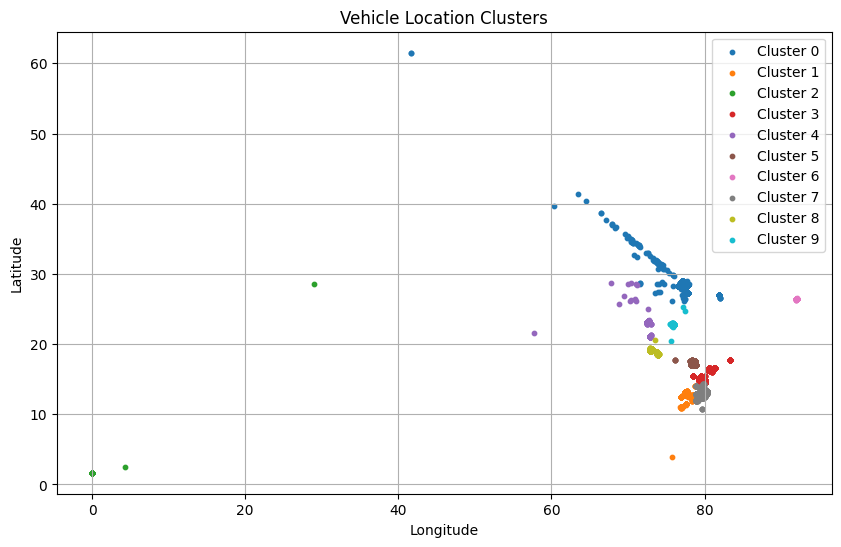

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for label in sorted(df['cluster'].unique()):
    group = df[df['cluster'] == label]
    plt.scatter(group['avg_long'], group['avg_lat'], label=f"Cluster {label}", s=10)

plt.title("Vehicle Location Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


##### Using elbow method for optimal cluster number

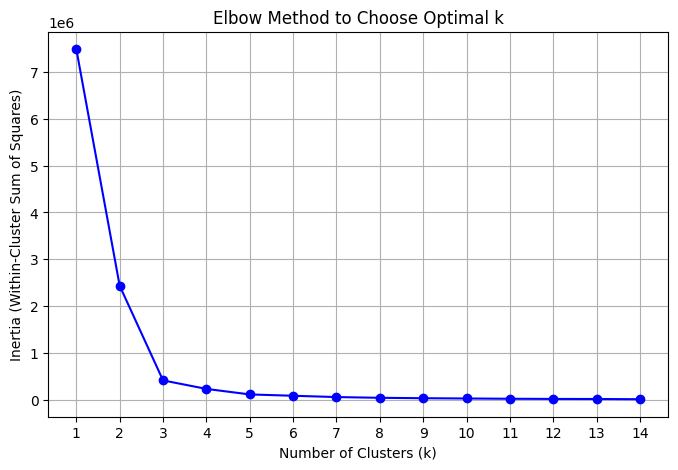

In [11]:


# Assume df has cleaned lat-long data
locations = df[['avg_lat', 'avg_long']].dropna().to_numpy()

inertias = []
k_values = range(1, 15)  # try k from 1 to 14

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(locations)
    inertias.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method to Choose Optimal k")
plt.grid(True)
plt.xticks(k_values)
plt.show()


##### We get 3 as optimum cluster number while checking upto 14 for number of clusters


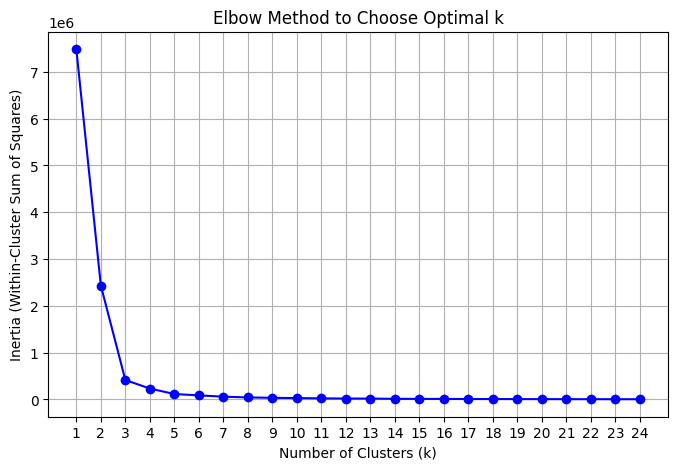

In [12]:


# Assume df has cleaned lat-long data
locations = df[['avg_lat', 'avg_long']].dropna().to_numpy()

inertias = []
k_values = range(1, 25)  # try k from 1 to 24

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(locations)
    inertias.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method to Choose Optimal k")
plt.grid(True)
plt.xticks(k_values)
plt.show()


##### Again k = 3 is the optimum number of clusters


In [45]:
#From elbow method, let's choose k=3 for clustering

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(locations)

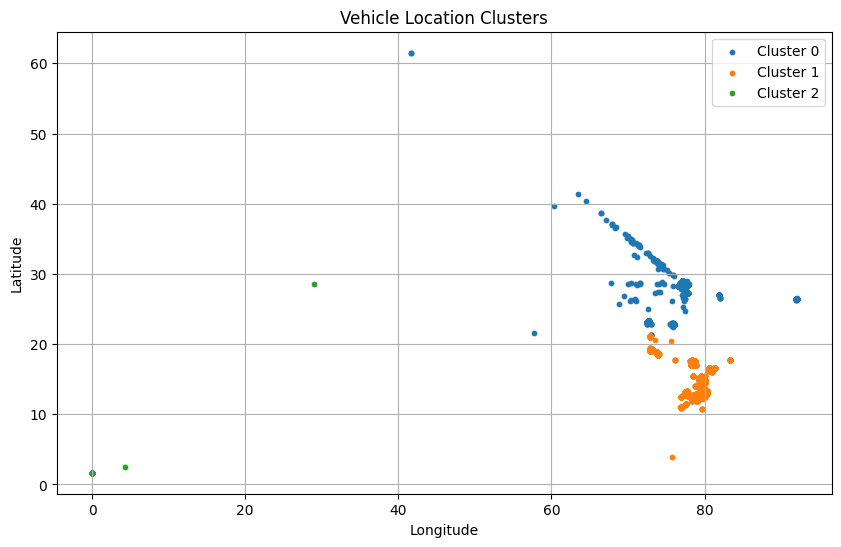

In [46]:


plt.figure(figsize=(10, 6))
for label in sorted(df['cluster'].unique()):
    group = df[df['cluster'] == label]
    plt.scatter(group['avg_long'], group['avg_lat'], label=f"Cluster {label}", s=10)

plt.title("Vehicle Location Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
median_count = cluster_counts['count'].median()

cluster_counts['density_level'] = cluster_counts['count'].apply(
    lambda x: 'High' if x >= median_count else 'Low'
)


In [48]:
df = df.merge(cluster_counts[['cluster', 'density_level']], on='cluster', how='left')


#### Density regions using K-Means

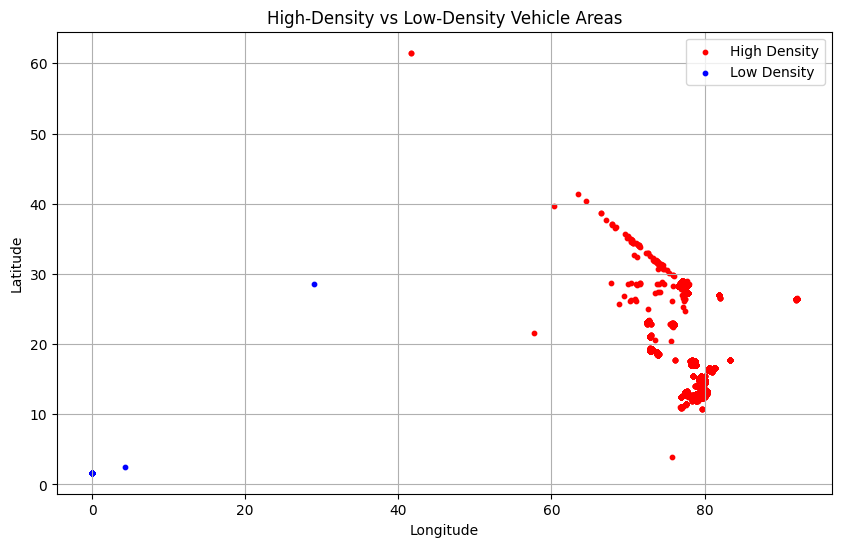

In [17]:
colors = {'High': 'red', 'Low': 'blue'}

plt.figure(figsize=(10, 6))
for level in ['High', 'Low']:
    subset = df[df['density_level'] == level]
    plt.scatter(subset['avg_long'], subset['avg_lat'], 
                s=10, label=f'{level} Density', color=colors[level])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("High-Density vs Low-Density Vehicle Areas")
plt.legend()
plt.grid(True)
plt.show()


In [49]:
df.to_excel("Q4_Density_Clusters_KMeans.xlsx", index=False)


##### Clustering with DBSCAN

In [38]:
unique_locations = df.drop_duplicates(subset=['vin', 'avg_lat', 'avg_long'])


In [39]:
from sklearn.cluster import DBSCAN


# Create coordinate array
coords = unique_locations[['avg_lat', 'avg_long']].to_numpy()


In [40]:
# You may tune eps based on density scale (e.g., 0.001 ≈ 100m)
db = DBSCAN(eps=0.001, min_samples=5)
unique_locations['cluster'] = db.fit_predict(coords)


C:\Users\vedpr\AppData\Local\Temp\ipykernel_18644\1502111450.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_locations['cluster'] = db.fit_predict(coords)


#### Density regions using DBSCAN

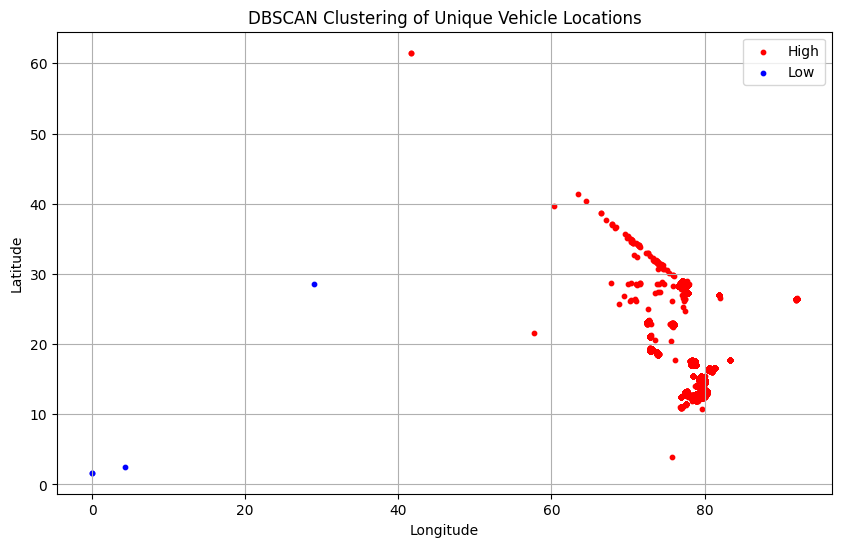

In [41]:
import matplotlib.pyplot as plt

colors = {'High': 'red', 'Low': 'blue', 'Noise': 'gray'}

plt.figure(figsize=(10, 6))
for label in unique_locations['density_level'].unique():
    subset = unique_locations[unique_locations['density_level'] == label]
    plt.scatter(subset['avg_long'], subset['avg_lat'], 
                s=10, label=label, color=colors.get(label, 'gray'))

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of Unique Vehicle Locations")
plt.legend()
plt.grid(True)
plt.show()


In [43]:
cluster_counts = unique_locations['cluster'].value_counts().reset_index()
cluster_counts.columns = ['cluster', 'count']

# Label high- and low-density clusters using median
median_count = cluster_counts['count'].median()
cluster_counts['density_level'] = cluster_counts['count'].apply(
    lambda x: 'High' if x >= median_count else 'Low'
)

# Merge labels back
unique_locations = unique_locations.merge(cluster_counts[['cluster', 'density_level']], on='cluster', how='left')


In [44]:
unique_locations.to_excel("Q4_DBSCAN_Unique_Locations.xlsx", index=False)



 So from both the clustering methods we get similar cluster density regions